In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# pickle dosyasını oku
with open("../tracker_stubs/ball_detections.pkl", "rb") as f:
    ball_positions = pickle.load(f)

In [3]:
ball_positions = [x.get(1, []) for x in ball_positions]
# get(1, []) -> 1. elemanı al, yoksa [] döndür. (1. eleman: topun pozisyonu)

df_ball_positions = pd.DataFrame(ball_positions, columns=["x1", "y1", "x2", "y2"])
df_ball_positions = df_ball_positions.interpolate(method="linear")
df_ball_positions = df_ball_positions.bfill()

In [4]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()
# window -> kaç veriyi alarak ortalama alınacak
# min_periods -> ortalama alınabilmesi için gereken minimum veri sayısı (1 olursa 1 veri ile ortalama alınır)
# center -> ortalama alınan verinin hangi veriye ait olduğu gösterir (True ise ortadaki veriye ait olacak) 
# center=False ise ortalama alınan veri, window kadar önceki verilere ait olacak
# center=True ise ortalama alınan veri, window kadar önceki ve sonraki verilere ait olacak

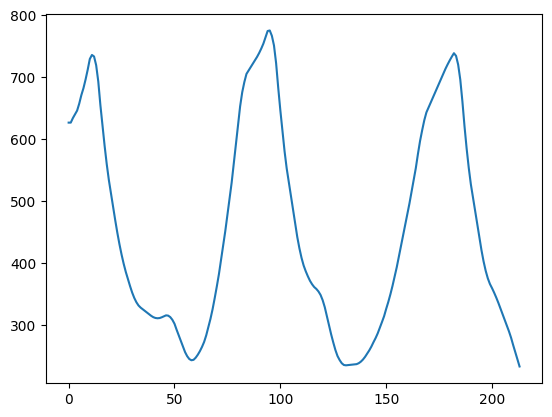

In [5]:
# mid_y_rolling_mean sütununu çizdir

plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [6]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()
# diff -> verinin bir önceki veriden farkını alır, böylece verinin değişimini görebiliriz.

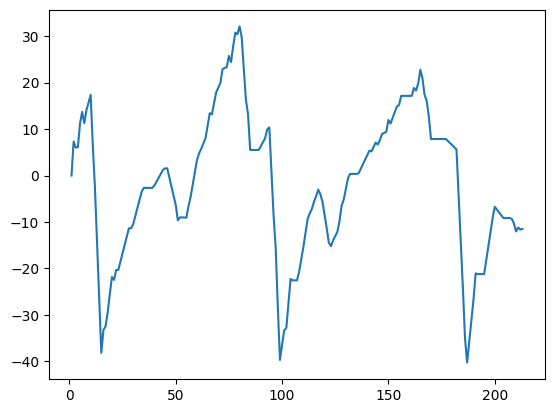

In [7]:
# delta_y sütununu çizdir
plt.plot(df_ball_positions['delta_y'])

In [8]:
df_ball_positions['ball_hit'] = 0

In [9]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

C:\Users\onure\AppData\Local\Temp\ipykernel_10620\3752280353.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\onure\AppData\Local\Temp\ipykernel_10620\3752280353.py:18: SettingWithCopyWa

In [10]:
df_ball_positions[df_ball_positions["ball_hit"] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,776.865967,717.330078,796.806519,738.393188,727.861633,735.918127,6.523413,1
58,925.881445,240.971048,939.039478,253.989072,247.480060,243.406101,-1.957852,1
95,624.777130,748.891968,642.157257,766.698273,757.795120,775.403409,0.871762,1
131,716.963562,229.095032,729.239899,242.786263,235.940647,235.241701,-0.557162,1
182,1294.891357,739.127197,1314.160156,760.564819,749.846008,738.733591,5.602820,1


In [11]:
frame_nums_with_ball_hits = df_ball_positions[df_ball_positions["ball_hit"] == 1].index.tolist()
# ball_hits sütununda 1 olan değerlerin indexlerini alır
# indexler frame numaralarını verir
# bu frame numaraları ile o frame numaralarına ait görüntüleri alabiliriz